#### Figure 3B

Average depth:  44.281030445
Average depth:  31.793911007
Looking at 854 positive sites and 854 null sites
Recall 0.915690866511
Precision 0.839055793991


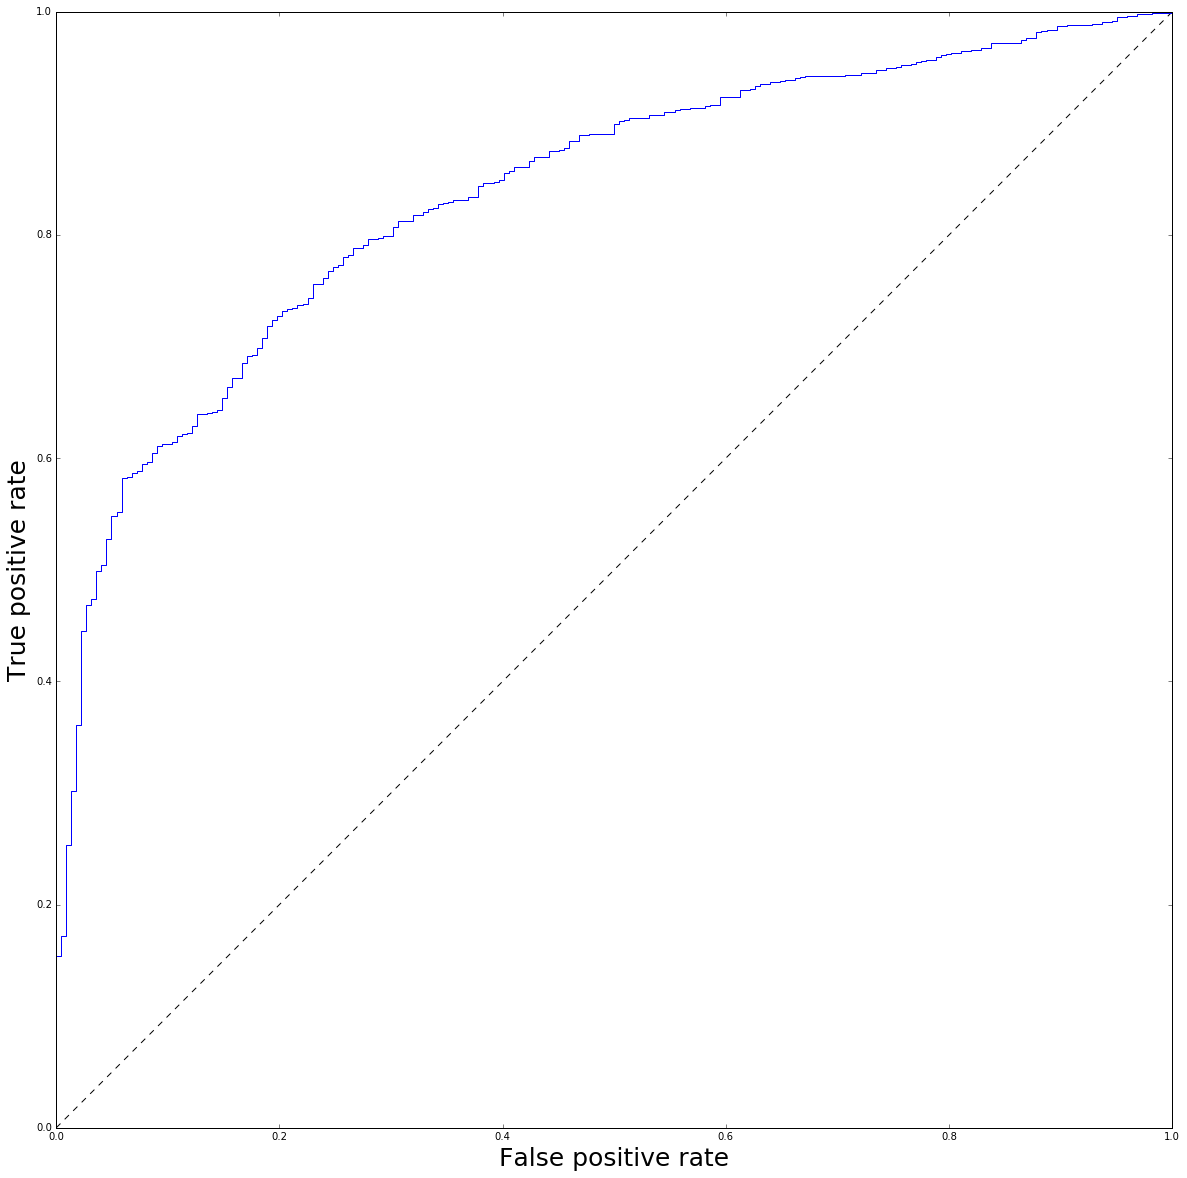

In [7]:
from __future__ import division
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from collections import Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

def parse_substitution_file(substitution_file):
    fH = open(substitution_file, 'r')
    line = fH.readline().split()
    forward_sub = line[0]
    forward_pos = map(np.int64, line[1:])
    line = fH.readline().split()
    backward_sub = line[0]
    backward_pos = map(np.int64, line[1:])
    return (forward_sub, forward_pos), (backward_sub, backward_pos)

def load_data(file_path):
    data = pd.read_table(file_path, 
                         usecols=(0, 1, 2, 3, 4, 5),
                         names=['site', 'strand', 'pC', 'pmC', 'phmC', 'read'],
                         dtype={'site': np.int64,
                                'strand': np.str, 
                                'pC': np.float64, 
                                'pmC': np.float64, 
                                'phmC': np.float64, 
                                'read': np.str,
                               })
    return data

def get_probability_for_position(data, position):
    s = data.ix[(data['site'] == position) | (data['site'] == position + 2)]
    collect = []
    for i, row in enumerate(s.iterrows()):
        if row[1]['read'].endswith(".forward.tsv"):
            forward = True
        else:
            forward = False
        df = pd.DataFrame({'site': row[1]['site'], 
                           'loc': str(position),
                           'pC': row[1]['pC'],
                           'pmC': row[1]['pmC'],
                           'phmC': row[1]['phmC'],
                           'strand': row[1]['strand'],
                           'forward': forward},
                         columns=['site', 'loc', 'pC', 'pmC', 'phmC', 'strand', 'forward'], 
                         index=[i])
        collect.append(df)
    collect = [x for x in collect if not x.empty]
    if len(collect) > 0:
        return pd.concat(collect)
    else:
        return None

def call_sites(data, sites, min_depth, threshold, label):
    c_mapped = []
    mc_mapped = []
    
    calls = []
    depths = []
    for site in sites:
        d = get_probability_for_position(data, site)
        if d is None:
            continue
        select = d.ix[((d['pC'] >= threshold) | (d['pmC'] >= threshold)) ]
                      #& (d['strand'] == 't') ]
                      #& (d['forward'] == True)]
        if select.empty or select.shape[0] < min_depth:
            continue
        depths.append(select.shape[0])
        total = sum(select['pC']) + sum(select['pmC'])
        prob_C =  sum(select['pC']) / total
        prob_mC =  sum(select['pmC']) / total
        if np.argmax([prob_C, prob_mC]) == label:
            calls.append((0, max(prob_C, prob_mC)))
        else:
            calls.append((1, max(prob_C, prob_mC)))    
    print "Average depth: ", np.mean(depths)
    return calls

def calculate_precision_and_recall(positive_data_filepath, positive_sites_file, 
                                   null_data_filepath, null_sites_file,
                                   min_depth, threshold):
    mf, mb = parse_substitution_file(positive_sites_file)
    methyl_sites = mf[1]
    methyl_data = load_data(positive_data_filepath)
    
    cf, cb = parse_substitution_file(null_sites_file)
    cytosine_sites = cf[1]
    cytosine_data = load_data(null_data_filepath)
    
    experiment_calls = call_sites(methyl_data, methyl_sites, min_depth, threshold, 1) # 1 is the mC label
    control_calls = call_sites(cytosine_data, cytosine_sites, min_depth, threshold, 0) # 0 is the C label
    
    true_positive = [x[0] for x in experiment_calls].count(0)  # 0 here means correct
    false_negative = [x[0] for x in experiment_calls].count(1)
    
    true_negative = [x[0] for x in control_calls].count(0)
    false_positive = [x[0] for x in control_calls].count(1)
    
    print "Looking at {pos} positive sites and {null} null sites".format(
        pos=(false_negative + true_positive), null=(true_negative + false_positive))
    
    print "Recall", true_positive / (true_positive + false_negative)
    print "Precision", (true_positive) / (true_positive + false_positive)
    return experiment_calls, control_calls

def roc2(exp_calls, cont_calls):
    all_calls = exp_calls + cont_calls
    fpr, tpr, _ = roc_curve([x[0] for x in all_calls], 
                            [x[1] for x in all_calls], pos_label=0)
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    return df

genomicTest = "../data/ecoli/genomic_calls.tsv"
pcrTest = "../data/ecoli/pcr_calls.tsv"
testSites = "../data/ecoli/test_sites.tsv"

exp_calls0, con_calls0 = calculate_precision_and_recall(genomicTest, testSites, pcrTest, testSites, 0, 0.0)

df_0 = roc2(exp_calls0, con_calls0)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(df_0['fpr'], df_0['tpr'], color='b')

plt.xlabel('False positive rate', fontsize=25)
plt.ylabel('True positive rate', fontsize=25)
plt.show()



